<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Light_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Jack3690/INSIST --quiet
!pip install git+https://github.com/Srivardini/tara --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00


In [2]:
import pista as pt
from pista.utils import Xmatch, generate_psf
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter
from PIL import Image, ImageDraw
import cv2
import imageio
from glob import glob
from scipy.stats import skewnorm
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.io import fits

In [3]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
data_path = pt.data_dir

In [5]:
def light_curve(x, y, cadence):
  x_new = np.arange(x[0], x[-1], cadence)
  y_new = np.interp(x_new, x, y)
  return x_new, y_new

In [6]:
start = 0
end = 12*60

num_points = 1000

x_in = np.arange(start, end, 1)
y_in = skewnorm.pdf(x_in, 10, loc=100, scale=3*60)

t,dmag = light_curve(x_in, y_in, 0.1)
dmag = -dmag/dmag.max()

In [7]:
x_in = np.arange(0, len(y_in), 1)
t,dmag = light_curve(x_in, y_in, 0.1)
dmag /= dmag.max()
len(dmag)

7190

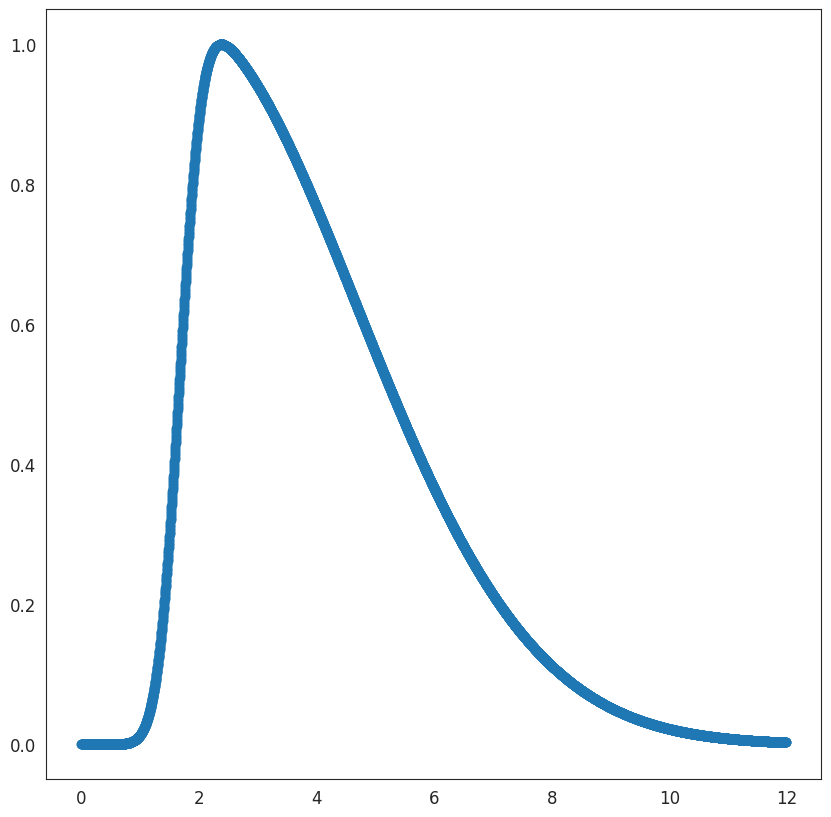

In [9]:
plt.plot(t/60,dmag,'o')

In [10]:
fwhm = 3
sigma = fwhm*gaussian_fwhm_to_sigma

In [11]:
params = {
          'sigma_x' : sigma,
          'sigma_y' : sigma,
}

In [13]:
psf = generate_psf(201, params, 'Gaussian' )

In [14]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [86]:
tel_params ={
            'aperture'       : 11*2.5,
            'pixel_scale'    : 1.25,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [],
             'coeffs'        : 5.19999,#17.84130659,
             'theta'         : 0,
              'M_sky'        : 13,
            }

In [70]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         : 1,
              'FWC'        : 14e3,
              'bit_res'    : 12,
              'bias'       : 10,
              'DFM'        : 0.001424*0.24865623509739707,
              'PRNU_frac'  :  0.25/100,
              'pixel_area' : 1.089e-07,
              'DCNU'       :  0.01/100,
              'RN'         :  3.4,
              'T'          :  300,
              'DN'         :  0.01/100
              }

Proxima flux : 30,077
sky_flyx: 2325

r:2
r_in:6
r_out:11


# **Example 1**

In [17]:
if not os.path.exists('/content/output'):
  os.mkdir('/content/output')

if not os.path.exists('/content/tar_out'):
  os.mkdir('/content/tar_out')

In [61]:
ra = np.random.uniform(10 - 120/3600, 10 + 120/3600,10)
dec = np.random.uniform(10 - 120/3600, 10 + 120/3600,10)
mag = np.random.uniform(11.5,13,10)
df = pd.DataFrame(zip(ra, dec, mag), columns = ['ra', 'dec', 'mag'])

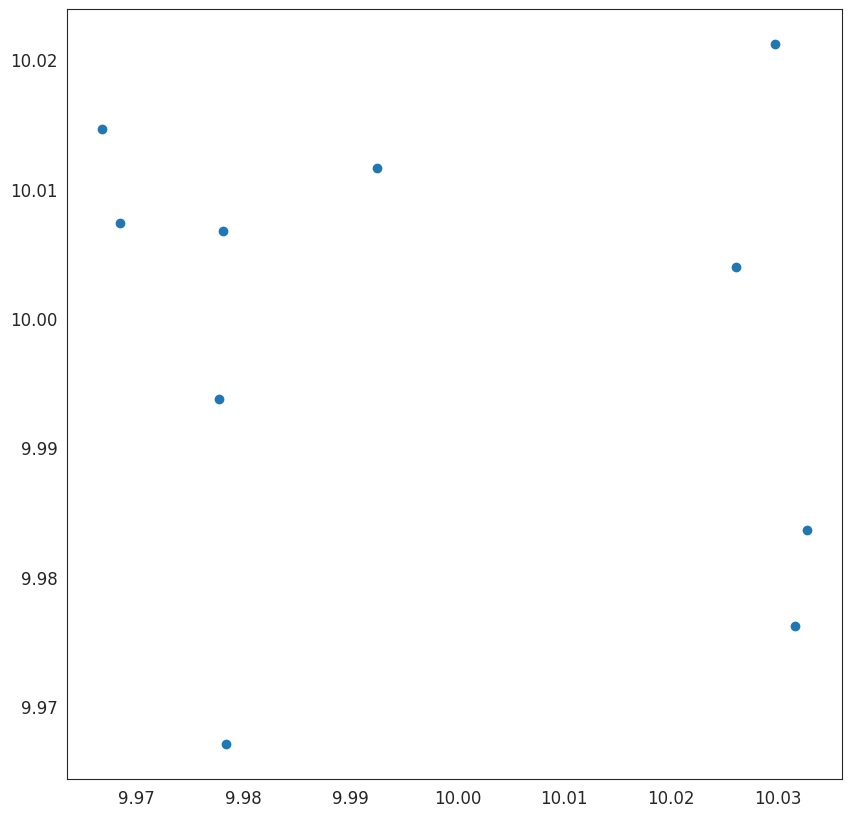

In [62]:
plt.scatter(ra, dec)

In [63]:
150*1.25

187.5

In [87]:
tabs = []
for i in range(len(dmag)):
  df['ra'] = ra + np.random.uniform(-2/3600,2/3600,1)[0]
  df['dec'] = dec + np.random.uniform(-2/3600,2/3600,1)[0]
  df['mag'][0] =  11 - dmag[i]

  sim = pt.Imager(df = df,tel_params = tel_params, coords=(10,10),
                  exp_time = 0.1, plot = False,
             n_x = 300, n_y = 300)

  sim(det_params = det_params, photometry = 'Aper', detect_sources=False,
      sigma=4, fwhm=2)

  tabs.append(sim.phot_table[sim.phot_table['mag_in']==10 - dmag[i]])
  sim.writecomp(f'/content/output/{i}_sim.fits')
  break

Response functions not provided. Using default values


  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 10 degrees, Dec : 10 degrees'}>)

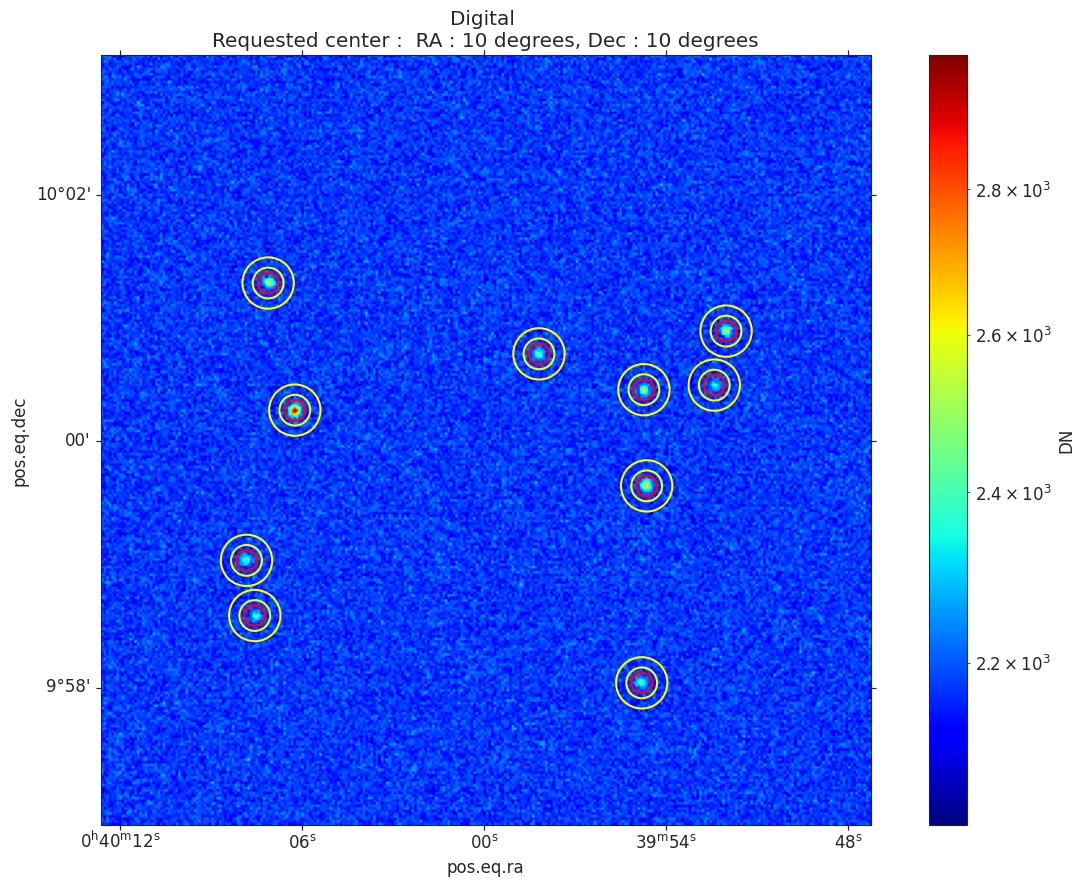

In [89]:
sim.show_image(overlay_apertures=True)

In [88]:
sim.phot_table

id,xcenter,ycenter,aperture_sum,sky_flux,flux,flux_err,SNR,ra,dec,mag_in,mag_out,mag_err
,pix,pix,,electron,electron,electron,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,75.15185139404421,161.1075945551395,118019.96940099048,373334.10823245585,30054.45905608585,635.7025007805241,47.27755360280096,10.02603761817969,10.004203013725595,10.999999987694956,10.996673849935348,0.02288612496937441
2,170.29292501432477,183.03930763937458,111908.05980020131,374021.3316254286,8476.91964479076,619.0535949982763,13.693353391824441,9.99249229546734,10.011819119661533,12.343541479778953,12.370850973004329,0.07901643732104391
3,212.23428321351025,131.607298945364,114158.77292391645,373677.7199289422,16513.398463350313,625.2361318752804,26.411459001611792,9.97770535507669,9.993960126369814,11.668858196523802,11.64685498787966,0.040967066602945704
4,210.31488831971097,54.86979391982993,111834.18891837183,372990.49653596943,9255.266368621786,618.8496304553003,14.955598118096148,9.978383852607845,9.967315209088456,12.391891500864988,12.27547383303314,0.07234749098337893
5,59.54143381596634,81.09115696044681,111274.24723545297,373849.5257771854,6482.373953366769,617.3013866342944,10.501149185344529,10.031538891778707,9.976419060862366,12.328103241481218,12.662110936742058,0.10303634210911375
6,56.32225595657674,102.58195166729735,111798.2065056067,372475.07899123983,9647.697150970518,618.7502552341138,15.592231387961467,10.03267457286004,9.983881031726654,12.390783562444124,12.230386983548186,0.06939353150155252
7,64.76901621678707,210.6380186279212,113075.78345562026,374021.3316254286,12468.162607648468,622.2689100727655,20.036615048292376,10.029700002991847,10.021400769722046,11.90572336867071,11.951939994843643,0.054001137287518715
8,238.58005407936736,170.8659085617997,111325.86269180142,372904.5936118478,7603.726135520323,617.4442662762677,12.314838036115361,9.968415247571302,10.007590839475677,12.857302818643701,12.488879972860966,0.0878614884602502


In [ ]:
sim.det_params

In [ ]:
tab_t = vstack(tabs)

In [ ]:
tab_t.write('/content/pista_phot.fits', overwrite=True)

In [ ]:
!zip /content/sim.zip /content/output/*

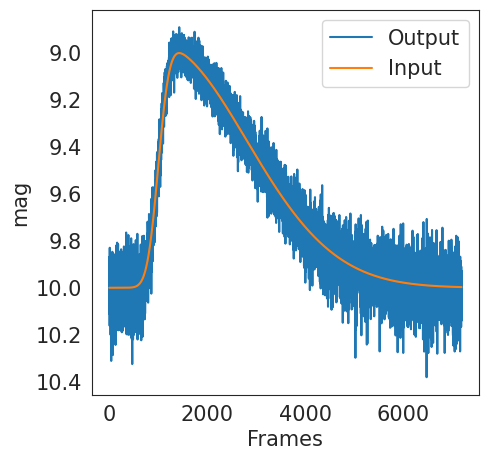

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(tab_t['mag_out'])
ax.plot(tab_t['mag_in'])
ax.set_xlabel('Frames')
ax.set_ylabel('mag')
ax.invert_yaxis()
plt.legend(['Output','Input'])

# **TARA**

In [ ]:
import tara
from tara.utils import gen_plot

In [ ]:
exps = glob('/content/output/*.fits')

In [ ]:
exps = sorted(exps, key=lambda x: int(x.split('/')[-1].split('_')[0]))

In [ ]:
tar_obj = tara.tara(exps, '/content/tar_out')

-------------------------------------------------
Input directory contains 7190 '.fits' 'files
Image shape: (300, 300)
-------------------------------------------------


In [ ]:
tar_obj.show_image(th=0.5, r=3, r_in=5, r_out=7)

In [ ]:
rnge = [0,72]
step = 100

ref_pos, ref_img= tar_obj(th=0.8, rnge=rnge, step=step)

In [ ]:
phot_table = tar_obj.merge_phot_table('/content/tar_out')

100%|██████████| 72/72 [00:01<00:00, 42.55it/s]


In [ ]:
phot_table.write('/content/tara_phot.fits')

In [ ]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,SNR_mean
,pix,pix,,,,,,,
int64,float64,float64,float64,float64,float64[7190],float64[7190],float64[7190],float64[7190],float64
10,134.0783463524306,210.7118060562003,15804.183540009206,8706.388221672323,11072.70212716662 .. 10748.627434163362,5348.635370929605 .. 5055.556105845844,16.614690679244564 .. 16.339282507677517,321.9220552574739 .. 309.41114479600526,338.6815375125798
6,184.97899656546366,151.7947745102783,15111.610822509863,8675.179748743221,11076.91189891243 .. 10710.098455238543,6313.913842145283 .. 4401.51236727132,17.03834283052573 .. 16.0245829886863,370.5708885510471 .. 274.67250601022704,298.4582425586848
4,124.96906651978303,130.75830071508477,11825.010903065984,6909.103529970453,9725.577816154671 .. 8529.757444407966,4373.800797528145 .. 3295.2534586580186,15.553182702727634 .. 14.437967592593036,281.2158052230102 .. 228.23527186392556,233.9360692601106
2,124.98439555212616,90.8946605734653,13000.248854331247,8174.69753772062,8954.83414916947 .. 10092.219182371135,4172.74002408765 .. 2908.029671960112,15.086757451933133 .. 15.024573845962664,276.5829594186906 .. 193.55155771965838,232.5850499579974
1,208.98015333401895,86.88096098567739,12471.845385098797,7370.441139354997,9079.54473549867 .. 9099.310048586416,4042.309235419214 .. 3372.535336512381,15.083969298259133 .. 14.763711592935124,267.98710309532015 .. 228.43411125195914,224.0766584512192
5,223.93066547730126,145.8188750358979,12278.197499067839,7193.497723657952,8905.063611853677 .. 8880.861387232038,3132.191707530468 .. 3397.3361118358007,14.545657414541644 .. 14.66694981819669,215.33517655923484 .. 231.63208124029057,217.10687430045945
3,110.38374645332577,93.57712334948435,10103.855389833177,5388.597852819323,6846.707814942813 .. 6652.58994175225,3141.969689644142 .. 3451.265448080928,13.470337979648376 .. 13.533063131310998,233.25099150378992 .. 255.0247061284928,213.54571619288637
9,90.05414207512838,208.6569265260954,11243.200135725085,6275.298646342322,8128.450820179797 .. 7747.282279434965,3289.9785274902724 .. 3495.9178562901197,14.22939800849771 .. 14.138559598084138,231.20995881382453 .. 247.2612455347883,194.28353368836952


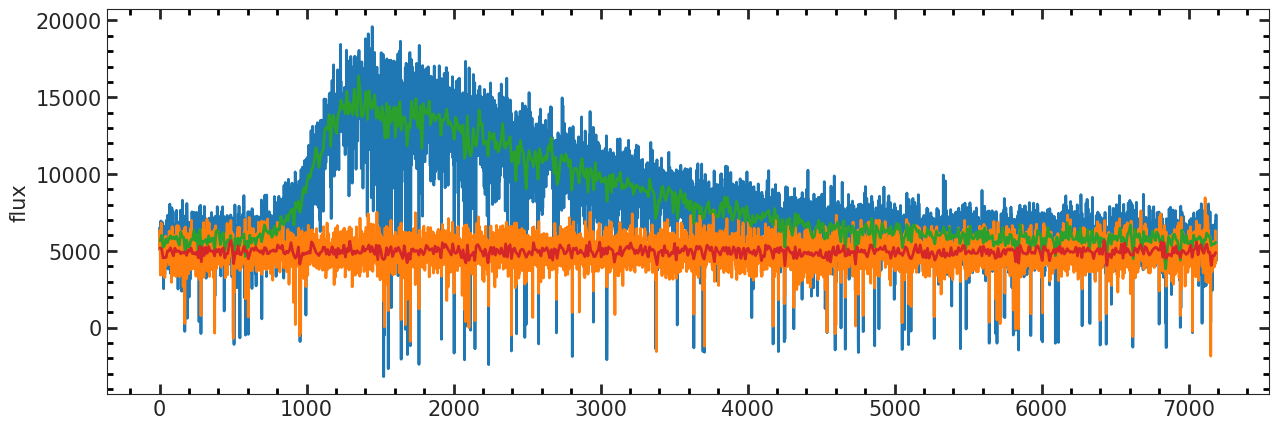

In [ ]:
fig, ax = gen_plot(phot_table[[0,1]], 'flux',out_dir='/content/tar_out',fmt='-',slice_end=None,
                   bin_fact=1)
fig, ax = gen_plot(phot_table[[0,1]], 'flux',out_dir='/content/tar_out',fmt='-',slice_end=None,
                   bin_fact=10,fig=fig,ax=ax)

In [ ]:
a =np.zeros(10)

In [ ]:
len(a[0:None])

10